
## Notebook Imports

In [1]:
import os
import re
from bs4 import BeautifulSoup 
from collections import Counter, OrderedDict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

In [49]:
# Paths
DIR_NAME = "SpamData\\01_Processing"
SUBDIR_NAME = "spam_assassin_corpus"
spam_1_path = os.path.join(".",DIR_NAME,SUBDIR_NAME,"spam_1")
spam_2_path = os.path.join(".",DIR_NAME,SUBDIR_NAME,"spam_2")
nonspam_1_path = os.path.join(".",DIR_NAME,SUBDIR_NAME,"easy_ham_1")
nonspam_2_path = os.path.join(".",DIR_NAME,SUBDIR_NAME,"easy_ham_2")

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON = os.path.join(os.getcwd(),DIR_NAME,"email-text-data.json")
WHALE_MASK = os.path.join(os.getcwd(),DIR_NAME,"wordcloud_resources","whale-icon.png")
SKULL_MASK = os.path.join(".",DIR_NAME,"wordcloud_resources","skull-icon.png")
THUMBUP_MASK = os.path.join(".",DIR_NAME,"wordcloud_resources","thumbs-up.png")
THUMBDOWN_MASK = os.path.join(".",DIR_NAME,"wordcloud_resources","thumbs-down.png")
OPEN_SANS_BOLD = os.path.join(".",DIR_NAME,"wordcloud_resources","OpenSansCondensed-bold.TTF")
OPEN_SANS_LIGHT = os.path.join(".",DIR_NAME,"wordcloud_resources","OpenSansCondensed-light.TTF")

# Email Body Extraction

In [3]:
def emailBodyExtraction(path):
    
    for root, dirname, filenames in os.walk(path):
        for file in filenames :
            is_body = False
            emailLines = []
            filePath = os.path.join(root, file)
            with open(filePath,'r',encoding = 'latin-1') as f:
                for line in f:
                    if is_body:
                        emailLines.append(line)
                    elif line == '\n':
                        is_body = True
                        
            emailBody = '\n'.join(emailLines)
            yield file, emailBody
                

In [4]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file, emailBody in emailBodyExtraction(path):
        rows.append({"CATEGORY": classification,'MESSAGE': emailBody})
        row_names.append(file)
        
    return pd.DataFrame(rows, index=row_names)

In [5]:
# Spam Email Dataframe
spam_emails = df_from_directory(spam_1_path,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(spam_2_path,SPAM_CAT))

In [6]:
# Ham Email DataFrame
ham_emails = df_from_directory(nonspam_1_path,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(nonspam_2_path,HAM_CAT))

In [7]:
spam_emails.shape

(1898, 2)

In [8]:
ham_emails.shape

(3901, 2)

In [9]:
data = pd.concat([spam_emails, ham_emails])

In [10]:
data.shape

(5799, 2)

In [11]:
data

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...
...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."


# Data Cleaning: Checking for Missing Values

In [12]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [13]:
# Checking for empty emails
(data.MESSAGE.str.len() == 0).any()

True

In [14]:
(data.MESSAGE.str.len()==0).sum()

3

### Locate Empty Emails

In [15]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

### Removing System File Entries

In [16]:
data.drop(['cmds'],axis=0, inplace=True)

### Add DocIDs to track emails in Dataset

In [17]:
docIds = [x for x in range(0,len(data.index))]

In [18]:
data['DOC_ID'] = docIds

In [19]:
data['FILE_NAME'] = data.index

In [20]:
data.set_index('DOC_ID', inplace=True)

In [21]:
data

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676


### Saving Data to json file

In [22]:
data.to_json(DATA_JSON)

## Number of Spam Messages Visualised

In [23]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [24]:
spam_count = data.CATEGORY.value_counts()[1]
ham_count = data.CATEGORY.value_counts()[0]

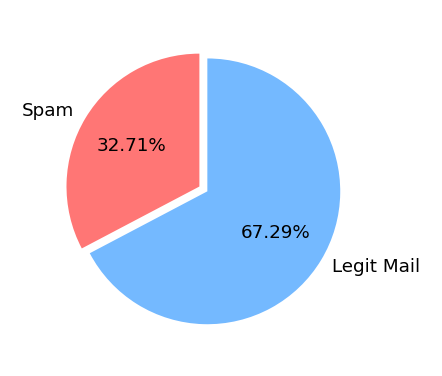

In [25]:
categoriesNames = ['Spam','Legit Mail']
sizes = [spam_count,ham_count]
custom_colors = ['#ff7675','#74b9ff']
# Pie Chart
plt.figure(figsize=(2,2),dpi=220)
plt.pie(sizes, labels = categoriesNames, textprops = {'fontsize':6},
       startangle=90, autopct = '%.2f%%',colors=custom_colors, explode=[0.02, 0.05])
plt.show()

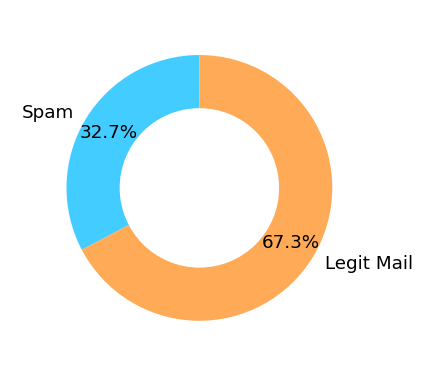

In [26]:
categoriesNames = ['Spam','Legit Mail']
sizes = [spam_count,ham_count]
custom_colors = ['#43ccff','#ffaa56']
# Pie Chart
plt.figure(figsize=(2,2),dpi=220)
plt.pie(sizes, labels = categoriesNames, textprops = {'fontsize':6},
       startangle=90, autopct = '%.1f%%',colors=custom_colors, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)
plt.show()

## Pre-Processing


- Converting to lower case
- Tokenising
- Removing stop words
- Stripping out HTML tags
- Word Stemming
- Remove punctuations

In [27]:
# Downloading the NLTK resources (Tokenizer and Stopwords)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ms151\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ms151\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\ms151\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\ms151\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Text pre-processing with an example

In [30]:
msg = "This is just an example we are going to tokenize, remove stopwords, word stemming and remove punctuations!!!.. yeah these"

words = word_tokenize(msg.lower())
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
filteredWords = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed = stemmer.stem(word)   
        filteredWords.append(stemmed)
        
print(filteredWords)

['exampl', 'go', 'token', 'remov', 'stopword', 'word', 'stem', 'remov', 'punctuat', 'yeah']


## Removing HTML tags from emails

In [63]:
def cleanEmails_no_html(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    # Removing HTML
    soup = BeautifulSoup(message,'html.parser')
    message = soup.get_text()
    # Tokenizing the message
    words = word_tokenize(message.lower())
    filtered_words = []
    
    for word in words:
        #Removing punctuations and stemming
        if word not in stop_words and word.isalpha():
#             filtered_words.append(word)
            filtered_words.append(stemmer.stem(word))

    
    
    return filtered_words

### Apply Cleaning and tokenisation to all messages

In [32]:
# Demonstration
first_emails = data.MESSAGE.iloc[0:3]
nested = first_emails.apply(cleanEmails_no_html)

In [33]:
flat_list = [item  for sublist in nested for item in sublist]

In [34]:
%%time

# Use apply() on all the messages in the DataFrame
nested_list = data.MESSAGE.apply(cleanEmails_no_html)

C:\Users\ms151\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 15.7 s


In [35]:
nested_list

DOC_ID
0       [save, life, insurance, spend, life, quote, sa...
1       [fight, risk, cancer, http, slim, guaranteed, ...
2       [fight, risk, cancer, http, slim, guaranteed, ...
3       [adult, club, offers, free, membership, instan...
4       [thought, might, like, slim, guaranteed, lose,...
                              ...                        
5791    [http, bizarre, collection, stuffed, animals, ...
5792    [careful, using, one, also, really, cute, thin...
5793    [sm, skip, montanaro, writes, jeremy, put, ano...
5794    [mark, hammond, like, given, zodb, sounding, a...
5795    [hi, probably, use, whatsoever, also, problem,...
Name: MESSAGE, Length: 5796, dtype: object

In [36]:
doc_id_spam = data[data.CATEGORY == 1].index
doc_id_ham = data[data.CATEGORY == 0].index
doc_id_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [37]:
ham_list = nested_list.loc[doc_id_ham]
spam_list= nested_list.loc[doc_id_spam]

In [38]:
## Long way of doing this

def wordData(nestedList, top = 10):
    # Creates a flatList
    flatList = [item
               for sublist in nestedList
               for item in sublist]
    
#     word_count = Counter(flatList)
#     top_n_count = sorted(word_count.values(),reverse=True)[:top]
#     top_n_words = dict([(key,value) for key, value in word_count.items()
#                         for count in top_n_count
#                        if count == value])

    word_count = pd.Series(flatList).value_counts()
    
    return word_count, flatList

In [39]:
word_count_ham, flatList_ham = wordData(ham_list, 20)

In [40]:
word_count_spam, flatList_spam = wordData(spam_list,20)

In [41]:
word_count_ham[:10]

http      6609
list      2662
one       2247
would     2003
get       1780
like      1729
use       1704
wrote     1679
new       1500
people    1458
dtype: int64

In [42]:
word_count_spam[:10]

http        2902
email       2775
free        2583
click       1945
please      1824
get         1710
business    1635
list        1549
money       1541
one         1504
dtype: int64

## Word Cloud

### Creating the word cloud for spam words

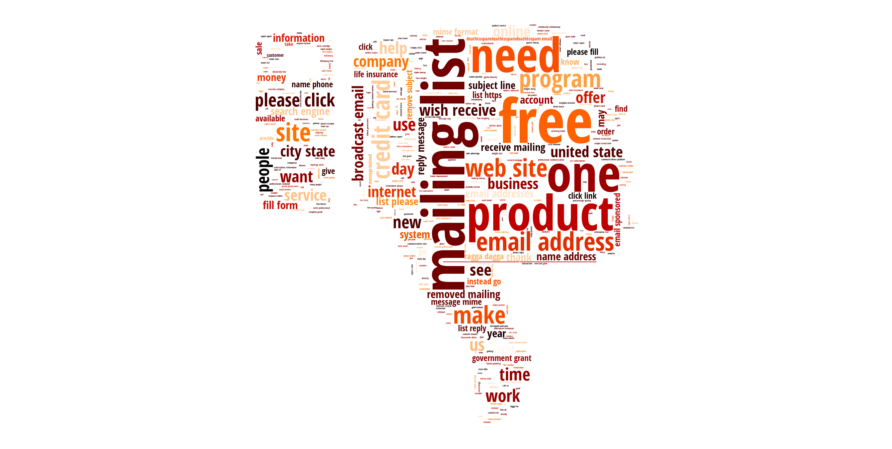

In [62]:
spam_words = " ".join(flatList_spam)

# Creating the mask
thumbdown_icon = Image.open(THUMBDOWN_MASK)
thumbDown = Image.new(mode='RGB',size = thumbdown_icon.size, color=(255,255,255))
thumbDown.paste(thumbdown_icon, box=thumbdown_icon)
thumbDown_mask = np.array(thumbDown)

# Creating Word cloud
word_cloud = WordCloud(font_path = OPEN_SANS_BOLD ,mask=thumbDown_mask, background_color = 'white',
                      max_words=400, colormap='gist_heat')
word_cloud.generate(spam_words)

# Plotting the image using the mask
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Creating the word cloud for ham words

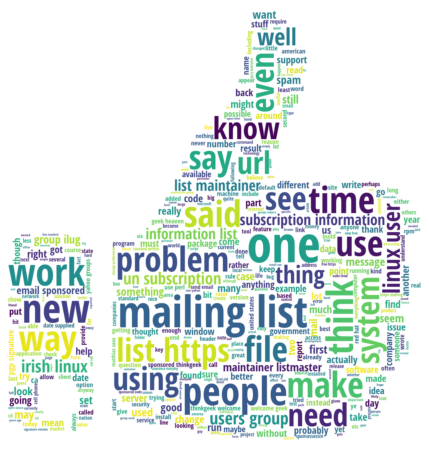

In [61]:

ham_words = " ".join(flatList_ham)

# Creating the mask
thumbup_icon = Image.open(THUMBUP_MASK)
thumbup = Image.new(mode='RGB',size = thumbup_icon.size, color=(255,255,255))
thumbup.paste(thumbup_icon, box=thumbup_icon)
thumbup_mask = np.array(thumbup)

# Creating Word cloud
word_cloud = WordCloud(font_path = OPEN_SANS_BOLD,mask=thumbup_mask, background_color = 'white',
                      max_words=400, colormap='viridis')
word_cloud.generate(ham_words)

# Plotting the image using the mask
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Generate Vocabulary & Dictionary

In [65]:
stemmedList = data.MESSAGE.apply(cleanEmails_no_html)
flatList = [item for sublist in stemmedList
           for item in sublist]

In [69]:
unique_words = pd.Series(flatList).value_counts()
unique_words.shape[0]

27334

In [72]:
frequent_words = unique_words[:2500]
top_10 = unique_words[:10]

In [73]:
top_10

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

'q=ye+ek+url+hai+%40python&w=ye+dusra+url'